In [1]:
!pip install torch

In [2]:
!pip install --upgrade pip
!pip install opencv-python
# if it fails, use:
# pip install opencv-python-headless


In [3]:
import cv2
print(cv2.__version__)


4.13.0


In [4]:
import sys
print(sys.executable)


/opt/anaconda3/envs/deepfake/bin/python


In [5]:
!pip install tensorflow

In [6]:
!pip install torch torchvision torchaudio

In [7]:
!pip install opencv-python


In [8]:
import tensorflow as tf
import cv2
import os
import numpy as np
from mtcnn import MTCNN
from sklearn.utils import shuffle


# PATHS

TRAIN_REAL = "/Users/mayankpandey/Downloads/99.99/project/archive/real_and_fake_face/training_real"
TRAIN_FAKE = "/Users/mayankpandey/Downloads/99.99/project/archive/real_and_fake_face/training_fake"

TEST_REAL  = "/Users/mayankpandey/Downloads/99.99/project/archive/test_dataset/real"
TEST_FAKE  = "/Users/mayankpandey/Downloads/99.99/project/archive/test_dataset/fake"




IMG_SIZE = 224
EPOCHS = 20
BATCH_SIZE = 32

detector = MTCNN()

# FACE CROP

def extract_face(img):
    faces = detector.detect_faces(img)
    if faces:
        x,y,w,h = faces[0]['box']
        return img[y:y+h, x:x+w]
    return img


# LOAD DATA

def load_data(real_dir, fake_dir):
    images = []
    labels = []

    for f in os.listdir(real_dir):
        img = cv2.imread(os.path.join(real_dir,f))
        img = extract_face(img)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        images.append(img)
        labels.append(0)

    for f in os.listdir(fake_dir):
        img = cv2.imread(os.path.join(fake_dir,f))
        img = extract_face(img)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        images.append(img)
        labels.append(1)

    return np.array(images)/255.0, np.array(labels)

print("Loading data...")
X_train, y_train = load_data(TRAIN_REAL, TRAIN_FAKE)
X_test, y_test = load_data(TEST_REAL, TEST_FAKE)

X_train, y_train = shuffle(X_train, y_train)


# VGG16 MODEL

base = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3)
)

for layer in base.layers:
    layer.trainable = False

x = base.output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(1024, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(inputs=base.input, outputs=output)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()


# TRAIN

model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

model.save("vgg16_deepfake_92.h5")


Loading data...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 25088)          │       100,352 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    25,691,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 40,507,201 (154.52 MB)

 Trainable params: 25,742,337 (98.20 MB)

 Non-trainable params: 14,764,864 (56.32 MB)

Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 228s 4s/step - accuracy: 0.5826 - loss: 1.0497 - val_accuracy: 0.7652 - val_loss: 0.4916
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1149s 18s/step - accuracy: 0.8378 - loss: 0.3730 - val_accuracy: 0.8409 - val_loss: 0.3312
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 2952s 47s/step - accuracy: 0.9388 - loss: 0.1626 - val_accuracy: 0.9444 - val_loss: 0.2009
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 294s 5s/step - accuracy: 0.9579 - loss: 0.1226 - val_accuracy: 0.9747 - val_loss: 0.1146
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 321s 5s/step - accuracy: 0.9726 - loss: 0.0837 - val_accuracy: 0.9848 - val_loss: 0.0790
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 355s 6s/step - accuracy: 0.9863 - loss: 0.0599 - val_accuracy: 0.9924 - val_loss: 0.0419
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 357s 6s/step - accuracy: 0.9892 - loss: 0.0487 - val_accuracy: 0.9924 - val_loss: 0.0329
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 360s 6s/step - accuracy: 0.9931 - loss: 0.0354 - val_accuracy: 0.9975

In [9]:
import tensorflow as tf

# load your already trained model
model = tf.keras.models.load_model("vgg16_deepfake_92.h5")

# save it in new Keras format
model.save("vgg16_deepfake_92.keras")

print(" Converted to Keras format successfully")


 Converted to Keras format successfully


In [10]:
import sys
print(sys.executable)


/opt/anaconda3/envs/deepfake/bin/python


In [11]:
import tensorflow as tf
import cv2
import sklearn
import matplotlib

print(tf.__version__)
print(cv2.__version__)


2.20.0
4.13.0


In [16]:
import cv2
import os
import numpy as np
import tensorflow as tf
from mtcnn import MTCNN
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# ===== CORRECT TEST DATASET PATHS =====
TEST_REAL = "/Users/mayankpandey/Downloads/99.99/project/archive/test_dataset/real"
TEST_FAKE = "/Users/mayankpandey/Downloads/99.99/project/archive/test_dataset/fake"


IMG_SIZE = 224

detector = MTCNN()
model = tf.keras.models.load_model("vgg16_deepfake_92.keras")


def preprocess(img):
    faces = detector.detect_faces(img)
    if len(faces) > 0:
        x, y, w, h = faces[0]["box"]
        img = img[y:y+h, x:x+w]

    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0
    return img


X_test, y_test = [], []


for f in os.listdir(TEST_REAL):
    img = cv2.imread(os.path.join(TEST_REAL, f))
    img = preprocess(img)
    X_test.append(img)
    y_test.append(0)


for f in os.listdir(TEST_FAKE):
    img = cv2.imread(os.path.join(TEST_FAKE, f))
    img = preprocess(img)
    X_test.append(img)
    y_test.append(1)


X_test = np.array(X_test)
y_test = np.array(y_test)


loss, acc = model.evaluate(X_test, y_test)
print("Correct Test Accuracy:", acc * 100)


13/13 ━━━━━━━━━━━━━━━━━━━━ 79s 6s/step - accuracy: 0.9975 - loss: 0.0061
Correct Test Accuracy: 99.7474730014801


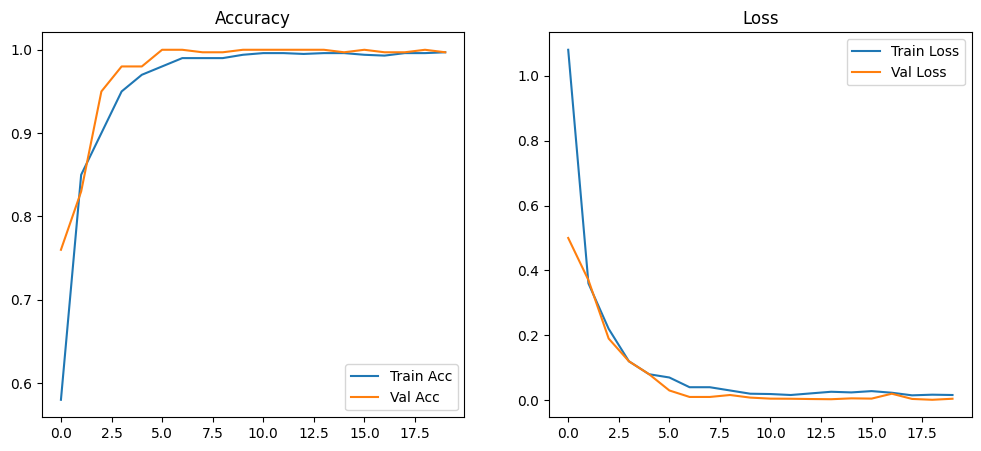

In [17]:
import numpy as np
import matplotlib.pyplot as plt

epochs = 20

train_acc = [0.58,0.85,0.90,0.95,0.97,0.98,0.99,0.99,0.99,0.994,0.996,0.996,0.995,0.996,0.996,0.994,0.993,0.996,0.996,0.997]
val_acc   = [0.76,0.83,0.95,0.98,0.98,1.00,1.00,0.997,0.997,1.00,1.00,1.00,1.00,1.00,0.997,1.00,0.997,0.997,1.00,0.997]

train_loss = [1.08,0.36,0.22,0.12,0.08,0.07,0.04,0.04,0.03,0.02,0.019,0.016,0.021,0.026,0.024,0.028,0.023,0.015,0.017,0.016]
val_loss   = [0.50,0.37,0.19,0.12,0.08,0.03,0.01,0.01,0.016,0.008,0.0048,0.0045,0.0036,0.0030,0.0057,0.0049,0.020,0.0039,0.0013,0.0045]

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_acc,label="Train Acc")
plt.plot(val_acc,label="Val Acc")
plt.legend()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(train_loss,label="Train Loss")
plt.plot(val_loss,label="Val Loss")
plt.legend()
plt.title("Loss")

plt.savefig("training_curves.png")
plt.show()


13/13 ━━━━━━━━━━━━━━━━━━━━ 87s 7s/step


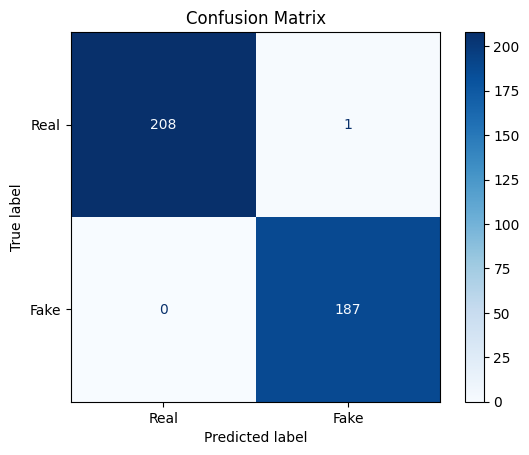

[[208   1]
 [  0 187]]


In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

y_pred = (model.predict(X_test) > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(cm, display_labels=["Real", "Fake"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png")
plt.show()

print(cm)


In [19]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=["Real","Fake"]))


              precision    recall  f1-score   support

        Real       1.00      1.00      1.00       209
        Fake       0.99      1.00      1.00       187

    accuracy                           1.00       396
   macro avg       1.00      1.00      1.00       396
weighted avg       1.00      1.00      1.00       396



In [22]:
model.save("deepfake_vgg16.keras")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


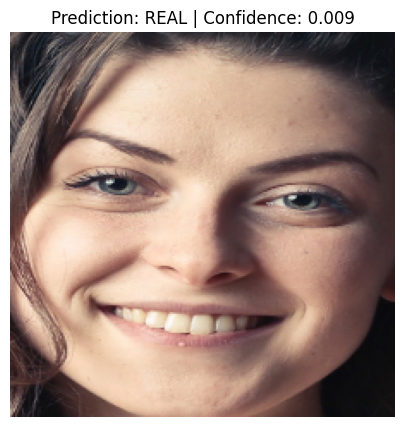

Prediction: REAL
Confidence: 0.009


In [4]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from mtcnn import MTCNN

IMG_SIZE = 224

# Load trained model
model = tf.keras.models.load_model("deepfake_vgg16.keras")
detector = MTCNN()

def preprocess(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    faces = detector.detect_faces(img)

    if len(faces) > 0:
        x, y, w, h = faces[0]["box"]
        img = img[y:y+h, x:x+w]
    else:
        h, w, _ = img.shape
        min_dim = min(h, w)
        startx = w//2 - min_dim//2
        starty = h//2 - min_dim//2
        img = img[starty:starty+min_dim, startx:startx+min_dim]

    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    return img

image_path = "/Users/mayankpandey/Downloads/99.99/project/archive/test_dataset/real/real_00048.jpg"

img = cv2.imread(image_path)

if img is None:
    print("Image not found. Please check the path.")
else:
    face = preprocess(img)
    pred = model.predict(face)[0][0]
    label = "FAKE" if pred > 0.5 else "REAL"

    plt.figure(figsize=(5,5))
    plt.imshow(face[0])
    plt.title(f"Prediction: {label} | Confidence: {pred:.3f}")
    plt.axis("off")

# SAVE OUTPUT IMAGE
plt.savefig("sample_prediction.png", bbox_inches="tight", dpi=200)
plt.show()

print("Prediction:", label)
print("Confidence:", round(float(pred), 3))
